For development and testing of the Module SlowSumOfBumpFcns

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import time
from typing import Callable

import matplotlib.pyplot as plt
import numpy as np
import torch

from janelia_core.math.basic_functions import generate_hypergrid_pts
from janelia_core.ml.generation import BumpFcnGenerator
from janelia_core.ml.utils import torch_mod_to_fcn
from janelia_core.ml.wandering_modules import SlowSumOfBumpFcns

## Parameters go here

In [3]:
n_dims = 3
n_smps = 100000

## Helper functions go here

In [4]:
def plot_2d_f(f: Callable, n_smps_per_dim = 100, dims=[0, 1], fixed_values=None):
    
    pts = generate_hypergrid_pts(d = 2, n_smps_per_dim=n_smps_per_dim)

    if fixed_values is None:
        full_pts = np.zeros([pts.shape[0], n_dims])
    else:
        full_pts = np.tile(np.expand_dims(fixed_values, 1), pts.shape[0]).transpose()
    
    
    full_pts[:, dims[0]] = pts[:,0]
    full_pts[:, dims[1]] = pts[:, 1]
    
    y_grid = f(full_pts).reshape([n_smps_per_dim, n_smps_per_dim])
    plt.imshow(y_grid)
    plt.colorbar()

In [52]:
def fit(nn: torch.nn.Module, x: torch.Tensor, y: torch.Tensor, n_its = 1000, lr=.01, batch_size: int = None,
        update_int=100):

    params = nn.parameters()
    
    optimizer = torch.optim.Adam(params = params, lr=lr)
    
    n_smps = x.shape[0]
    if batch_size is None:
        batch_size = n_smps
    
    t_last = time.time()
    for i in range(n_its):
        
        # Select samples for this iteration 
        if batch_size != n_smps:
            inds = torch.randperm(n_smps)[1:batch_size]
            batch_x = x[inds, :]
            batch_y = y[inds]
        else:
            batch_x = x
            batch_y = y
        
        optimizer.zero_grad()
        
        y_pred = nn(batch_x)
        er = torch.sum((batch_y - y_pred)**2)/batch_size
        er.backward()
        
        nn.pert_grads()
        optimizer.step()
        nn.bound()
        
        if i % update_int == 0:
            t_now = time.time()
            er_log = float(er.detach().cpu().numpy())
            print('It ' + str(i) +  ': {:e}'.format(er_log) + ', update int: ' + str(t_now - t_last) + ' secs')
            t_last = t_now
            #print('c: ' + str(nn.c))
            #print('w: ' + str(nn.w))
           # print('m: ' + str(nn.m))

## Generate the true function and data

In [63]:
run_on_gpu = True

In [54]:
fcn_generator = BumpFcnGenerator(n_bumps = 20, d=n_dims, bump_peak_vl_range = [-1, 1], cov_ev_range = [.01, .01])
f_true = fcn_generator.generate()

x = np.random.rand(10000,n_dims)
y = f_true(x)

x = torch.tensor(x, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

In [64]:
n_fit_bumps = 20
f_fit = SlowSumOfBumpFcns(c=torch.rand([n_dims, n_fit_bumps]), w=5*torch.ones([n_dims, n_fit_bumps]),
                      m=torch.zeros(n_fit_bumps),
                      c_bounds=torch.stack((torch.zeros(n_dims), torch.ones(n_dims))).t(),
                      w_bounds=torch.stack((.01*torch.ones(n_dims), 10*torch.ones(n_dims))).t(), 
                      support_p=.1)

In [65]:
if run_on_gpu:
    f_fit.to('cuda')
    x = x.to('cuda')
    y = y.to('cuda')
else:
    f_fit.to('cpu')
    x = x.to('cpu')
    y = y.to('cpu')

In [68]:
t_0 = time.time()

for i in range(1):
    fit(nn=f_fit, x=x, y=y, lr=.01, n_its=1001, batch_size=100000, update_int=100)

    t_stop = time.time()
print('Elapsed time: ' + str(t_stop - t_0))

It 0: 5.126525e-04, update int: 0.06129598617553711 secs
It 100: 5.088238e-04, update int: 4.002636194229126 secs
It 200: 4.720435e-04, update int: 4.7408246994018555 secs
It 300: 4.583886e-04, update int: 3.923011064529419 secs
It 400: 4.476473e-04, update int: 3.7881641387939453 secs
It 500: 4.442468e-04, update int: 4.0153913497924805 secs
It 600: 4.241696e-04, update int: 3.7394652366638184 secs
It 700: 3.780682e-04, update int: 3.9530928134918213 secs
It 800: 3.614364e-04, update int: 3.826345920562744 secs
It 900: 3.541226e-04, update int: 4.077266454696655 secs
It 1000: 3.530147e-04, update int: 4.498343467712402 secs
Elapsed time: 40.627145290374756


In [24]:
f_fit.to('cpu') 
x = x.to('cpu')
y = y.to('cpu')

## View the true and fit functions

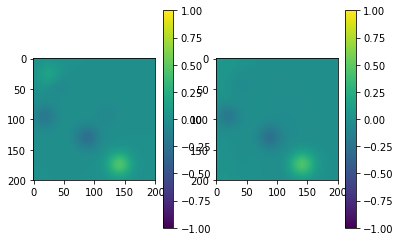

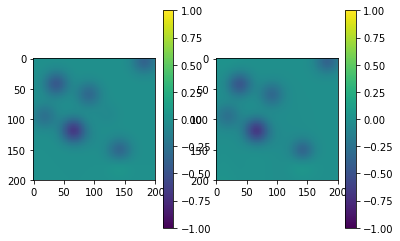

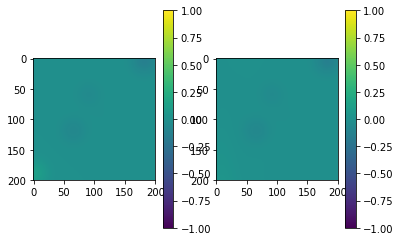

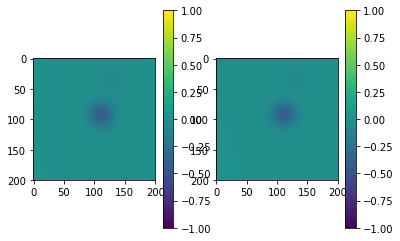

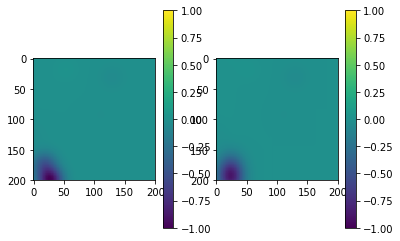

In [25]:
z_values = np.arange(0, 1, .2)
for z_v in z_values:
    plt.figure()
    plt.subplot(1,2,1)
    plot_2d_f(f_true, n_smps_per_dim=200, dims = [0, 1], fixed_values = z_v*np.ones(n_dims))
    plt.clim([-1, 1])
    plt.subplot(1,2,2)
    plot_2d_f(torch_mod_to_fcn(f_fit), n_smps_per_dim=200, dims = [0, 1], fixed_values = z_v*np.ones(n_dims))
    plt.clim([-1, 1])